In [129]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from Storage.storage import get_cursor, get_info_for_song_id
from Fingerprint.fingerprint import fingerprint_file
from recognise import recognise_song

In [9]:
# Baseline accuracy

TEST_DIR = "test/ab/"

correct = 0

for song in os.listdir(TEST_DIR):
    result = recognise_song(TEST_DIR + song)
    result_title = result[2]
    if result_title.replace(" ", "").lower() in song:
        correct += 1

print(f"{correct}/{len(os.listdir(TEST_DIR))}")

10/23


In [74]:
def shazam_match(offsets, fname, supposed):
    tks = list(map(lambda x: x[0] - x[1], offsets))
    # number of matches in highest peak
    hist, _ = np.histogram(tks)
#     plt.plot(_[:-1], hist)
#     plt.title(fname)
#     plt.show()
    return np.max(hist)

In [73]:
def new_get_matches(hashes, threshold=5):
    conn, c = get_cursor()
    h_dict = {}
    for h, t, _ in hashes:
        h_dict[h] = t
    in_values = f"({','.join([str(h[0]) for h in hashes])})"
    c.execute(f"SELECT hash, offset, song_id FROM hash WHERE hash IN {in_values}")
    results = c.fetchall()
    result_dict = defaultdict(list)
    for r in results:
        result_dict[r[2]].append((r[1], h_dict[r[0]]))
    return result_dict

def new_recognise_song(filename):
    hashes = fingerprint_file(filename)
    matches = new_get_matches(hashes)
    matched_song = None
    best_score = 0
    print(f"Recognising {filename} ---")
    for song_id, offsets in matches.items():
        score = shazam_match(offsets, song_id, filename.split("/")[-1])
#         print(f"{song_id} - {score}")
        if score > best_score:
            best_score = score
            matched_song = song_id
    info = get_info_for_song_id(matched_song)
    print(best_score)
    if info is not None:
        return info
    return matched_song

In [78]:
correct = 0

for song in os.listdir(TEST_DIR):
    result = new_recognise_song(TEST_DIR + song)
    result_title = result[2]
    if result_title.replace(" ", "").lower() in song:
        correct += 1
    else:
        print(f"{song} - {result_title}")
    print("--------")

print(f"{correct}/{len(os.listdir(TEST_DIR))}")

Recognising test/ab/openyoureyes1.wav ---
6
--------
Recognising test/ab/allhopeisgone1.wav ---
9
--------
Recognising test/ab/stillremains2.wav ---
7
stillremains2.wav - Wayward One
--------
Recognising test/ab/burnitdown2.wav ---
28
--------
Recognising test/ab/openyoureyes2.wav ---
9
--------
Recognising test/ab/brokenwings2.wav ---
44
--------
Recognising test/ab/brokenwings1.wav ---
58
--------
Recognising test/ab/onedayremains3(quiet).wav ---
8
onedayremains3(quiet).wav - Buried Alive
--------
Recognising test/ab/burnitdown1.wav ---
20
--------
Recognising test/ab/stillremains3.wav ---
4
stillremains3.wav - Broken Wings
--------
Recognising test/ab/wonderfullife2.wav ---
14
--------
Recognising test/ab/findthereal1.wav ---
6
findthereal1.wav - Broken Wings
--------
Recognising test/ab/onedayremains1.wav ---
16
--------
Recognising test/ab/makeitright1.wav ---
8
--------
Recognising test/ab/makeitright3.wav ---
7
makeitright3.wav - Peace Is Broken
--------
Recognising test/ab/find

In [76]:
wrong_songs = [
    "stillremains2.wav",
    "onedayremains3(quiet).wav",
    "stillremains3.wav",
    "findthereal1.wav",
    "makeitright3.wav",
    "findthereal3.wav",
    "onedayremains2(loud).wav",
    "makeitright2.wav",
    "stillremains1.wav",
]

for song in wrong_songs:
    result = new_recognise_song(TEST_DIR + song)

Recognising test/ab/stillremains2.wav ---
7
Recognising test/ab/onedayremains3(quiet).wav ---
8
Recognising test/ab/stillremains3.wav ---
4
Recognising test/ab/findthereal1.wav ---
6
Recognising test/ab/makeitright3.wav ---
7
Recognising test/ab/findthereal3.wav ---
10
Recognising test/ab/onedayremains2(loud).wav ---
8
Recognising test/ab/makeitright2.wav ---
10
Recognising test/ab/stillremains1.wav ---
4


# Using differentiation of the spectrogram to find peaks

Currently the application looks at a sorted list of the spectrogram values to find peaks. This may not match the criteria 

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


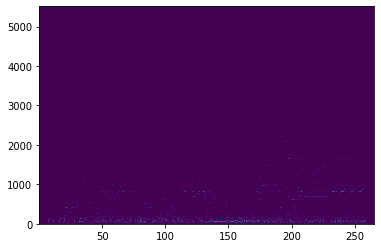

In [81]:
from scipy.ndimage import maximum_filter
from Fingerprint.fingerprint import file_to_spectrogram

ghost = "/media/cameron/Seagate Expansion Drive/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3"

f, t, Sxx = file_to_spectrogram(ghost, rate=11025)

plt.pcolormesh(t, f, Sxx)

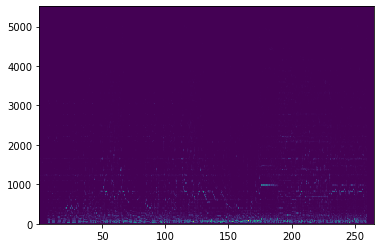

In [95]:
data_max = maximum_filter(Sxx, size=3, mode='constant', cval=0.0)

plt.pcolormesh(t, f, data_max)

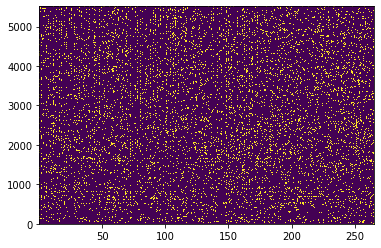

0.0073920256
158164


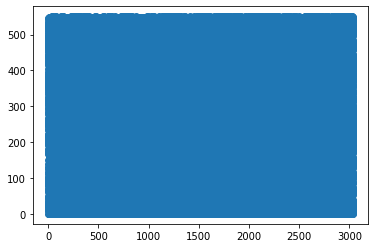

In [113]:
peak_goodmask = (Sxx == data_max)  # good pixels are True

plt.pcolormesh(t, f, peak_goodmask)
plt.show()

threshold = 0

print(np.max(Sxx))
peak_goodmask = np.logical_and(peak_goodmask, (Sxx > threshold))
y_peaks, x_peaks = peak_goodmask.nonzero()

plt.scatter(x_peaks, y_peaks)

print(len(y_peaks))

peak_values = Sxx[y_peaks, x_peaks]

Total: 1674216, peak_target: 1860.24


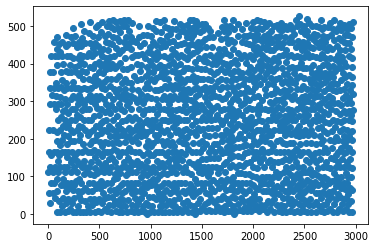

In [128]:
def find_peaks(peak_values, x_peaks, y_peaks, distance, sxx_shape, point_efficiency=0.4):                                                
    # get sorted flattened indices descending                                                            
    i = peak_values.argsort()[::-1]                                                                 
    # get co-ordinates into arr                                                                          
    j = [(y_peaks[idx], x_peaks[idx]) for idx in i]                                                    
    peaks = []                                                                                           
    total = sxx_shape[0] * sxx_shape[1]                                                                               
    # in a square with a perfectly spaced grid, we could fit area / distance^2 points                    
    # use point efficiency to reduce this, since it won't be perfectly spaced                            
    # accuracy vs speed tradeoff                                                                         
    peak_target = (total / (distance**2)) * point_efficiency
    print(f"Total: {total}, peak_target: {peak_target}")
    idx = 0
    for point in j:
#         print(f"{idx}/{total} - {len(peaks)}\r", end="")
        if len(peaks) > peak_target:                                                                     
            break                                                                                        
        for peak in peaks:                                                                               
            if abs(point[0] - peak[0]) + abs(point[1] - peak[1]) < distance:                             
                break                                                                                    
        else:                                                                                            
            peaks.append(point)
        idx += 1
    return peaks

peaks = find_peaks(peak_values, x_peaks, y_peaks, 30, Sxx.shape, point_efficiency=1)

y, x = zip(*peaks)
plt.scatter(x, y)
plt.show()

Found 1047 in 24.47454261779785


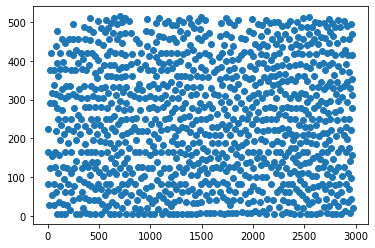

In [141]:
def full_find_peaks(Sxx, distance, point_efficiency=1):
    data_max = maximum_filter(Sxx, size=3, mode='constant', cval=0.0)
    peak_goodmask = (Sxx == data_max)  # good pixels are True
    y_peaks, x_peaks = peak_goodmask.nonzero()
    peak_values = Sxx[y_peaks, x_peaks]
    i = peak_values.argsort()[::-1]
    # get co-ordinates into arr
    j = [(y_peaks[idx], x_peaks[idx]) for idx in i]                                                    
    peaks = []                                                                                           
    total = Sxx.shape[0] * Sxx.shape[1]                                                                               
    # in a square with a perfectly spaced grid, we could fit area / distance^2 points                    
    # use point efficiency to reduce this, since it won't be perfectly spaced                            
    # accuracy vs speed tradeoff                                                                         
    peak_target = (total / (distance**2)) * point_efficiency
    for point in j:
        if len(peaks) > peak_target:                                                                     
            break                                                                                        
        for peak in peaks:                                                                               
            if abs(point[0] - peak[0]) + abs(point[1] - peak[1]) < distance:                             
                break                                                                                    
        else:                                                                                            
            peaks.append(point)
    return peaks

start = time.time()
peaks = full_find_peaks(Sxx, 40, 1)
print(f"Found {len(peaks)} in {time.time() - start}")

y, x = zip(*peaks)

plt.scatter(x, y)

Found 838 in 24.456568956375122


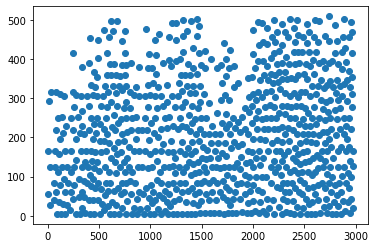

In [142]:
from Fingerprint.fingerprint import find_peaks

start = time.time()
peaks = find_peaks(Sxx, 40)
print(f"Found {len(peaks)} in {time.time() - start}")

y, x = zip(*peaks)

plt.scatter(x, y)

Old way/30/0.4 - 14/23  (42MB)  
New way/40/1   - 8/23   (6.5MB)

In [145]:
# Prove that checking the length of the offset before scoring is worth it

from timeit import timeit

def l():
    return len(peaks)

def h():
    return np.max(np.histogram(peaks)[0])

print(timeit(l, number=1000))

print(timeit(h, number=1000))

0.00012904498726129532
0.5639028790174052


Fast: 0.16012978553771973
Slow: 20.99373698234558


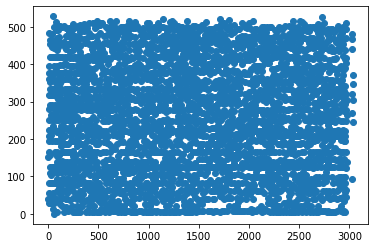

In [150]:
# Experiment with the effect that box size has

def faster_find_peaks(Sxx, distance, point_efficiency=1):
    data_max = maximum_filter(Sxx, size=distance, mode='constant', cval=0.0)
    peak_goodmask = (Sxx == data_max)  # good pixels are True
    y_peaks, x_peaks = peak_goodmask.nonzero()
    peak_values = Sxx[y_peaks, x_peaks]
    i = peak_values.argsort()[::-1]
    # get co-ordinates into arr
    j = [(y_peaks[idx], x_peaks[idx]) for idx in i]                                                    
    peaks = []                                                                                           
    total = Sxx.shape[0] * Sxx.shape[1]                                                                               
    # in a square with a perfectly spaced grid, we could fit area / distance^2 points                    
    # use point efficiency to reduce this, since it won't be perfectly spaced                            
    # accuracy vs speed tradeoff                                                                         
    peak_target = int((total / (distance**2)) * point_efficiency)
    return j[:peak_target]

start = time.time()
peaks = faster_find_peaks(Sxx, 20)
print(f"Fast: {time.time() - start}")

y, x = zip(*peaks)

plt.scatter(x, y)

start = time.time()
peaks = full_find_peaks(Sxx, 20, point_efficiency=0.6)
print(f"Slow: {time.time() - start}")

In [153]:
from Fingerprint.fingerprint import file_to_spectrogram, idxs_to_tf_pairs, hash_points

def my_fingerprint_file(filename, sample_rate=11025, distance=40, point_efficiency=1):
    start = time.time()
    f, t, Sxx = file_to_spectrogram(filename, rate=sample_rate)
    spectrogram = time.time()
    peaks = faster_find_peaks(Sxx, distance, point_efficiency=point_efficiency)
    peaks = idxs_to_tf_pairs(peaks, t, f)
    peaks_time = time.time()
    h = hash_points(peaks, filename)
    hashes = time.time()
    print(f"Spec: {spectrogram - start}\nPeak: {peaks_time - spectrogram}\nHash: {hashes - peaks_time}")
    return h

ghost = "/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3"
my_fingerprint_file(ghost, sample_rate=8000, point_efficiency=0.8)

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Spec: 12.264204502105713
Peak: 0.04604220390319824
Hash: 0.2275834083557129


[(-8975824424247479591,
  143.9,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (-1407893280292178729,
  90.9625,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (-798175595898774581,
  176.5375,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (-1407968952112108109,
  88.775,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (-1407020531968993213,
  103.7375,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (-1407373667128663653,
  73.2,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter Bridge - Ghost Of Days Gone By.mp3'),
 (2721412648964560135,
  53.5125,
  '/home/cameron/Music/Alter Bridge/(2010) AB III.5 (Special Edition)/Alter B

In [154]:
# since spectrogram is the bottleneck, let's try using the DCT to speed it up. See what results we get

import librosa.core as lr
from matplotlib.mlab import specgram
from scipy.signal import spectrogram

audio, _ = lr.load(ghost, sr=8000, mono=True)

start = time.time()
specgram(audio, NFFT=800, Fs=8000)
mlab = time.time()
spectrogram(audio, 8000, nperseg=800)
scipy = time.time()

print(f"mlab: {mlab - start}\nscipy {scipy - mlab}")

# It's not the spectrogram!

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


mlab: 0.09819912910461426
scipy 0.05022597312927246


In [155]:
start = time.time()
lr.load(ghost)
plain = time.time()
lr.load(ghost, mono=True)
mono = time.time()
lr.load(ghost, sr=8000)
resample = time.time()

print(
f"""plain: {plain - start}
mono: {mono - plain}
resample: {resample - mono}
""")

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


plain: 14.893885374069214
mono: 14.626835584640503
resample: 11.539310216903687



In [186]:
from pydub import AudioSegment

start = time.time()
a = AudioSegment.from_mp3(ghost).set_channels(1).set_frame_rate(8000)
data = np.frombuffer(a.raw_data, np.int16)
pd = time.time()

audio, _ = lr.load(ghost, sr=8000, mono=True)

print(audio[10000:10100])
print(data[10000:10100])

print(f"pydub: {pd - start}")

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


[ 0.05552707  0.00489142  0.01636244 -0.01467866 -0.05153009 -0.05110818
 -0.0449116  -0.00945169  0.04259708  0.01074309 -0.04063095  0.02056208
  0.08740058  0.07339241  0.03985558 -0.0195197  -0.06441836 -0.00337867
  0.02683116  0.00646249 -0.00499134  0.01640125  0.04047276  0.02089412
 -0.0518968  -0.07657049 -0.01384349 -0.00948169  0.00597087 -0.03030136
 -0.03806715  0.03117292  0.04775202  0.00742341 -0.05316981 -0.04347666
  0.0100622   0.04659323  0.03035244 -0.00228488  0.01602466  0.057573
  0.06020971  0.02378407 -0.04631675 -0.05743073 -0.05631533 -0.03841159
 -0.02123803  0.00189989  0.10060142  0.13468702  0.07002293 -0.05390365
 -0.13429312 -0.08879266  0.00084067  0.04688384  0.0439015   0.02426274
 -0.0191615  -0.06338135 -0.05745476 -0.05251715 -0.0075714   0.04980645
  0.05262871 -0.03577922 -0.09238119 -0.02432924  0.070814    0.13700804
  0.09992075  0.02811623 -0.04758018 -0.08584245 -0.0481339  -0.0058002
  0.04661754  0.07733663  0.0768951  -0.00668941 -0.12